#### DETECCION DE LOGOTIPO UNICO

In [3]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline
#%matplotlib

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

#### Funcion de deteccion

In [17]:
def single_detection(img, templ):
    
    # Metrica de evalucion
    #methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
    meth = 'cv.TM_CCOEFF_NORMED' 
    # Parametros de la funcion de canny para la imagen
    img_canny = [75,200]
    # Parametros de la funcion de canny para el template
    templ_canny =[150,250]
    # Step de factor de escala para la busqueda
    n_step = 25
    # Rango de relacion de aspecto de la imagen para la busqueda. Permite deformar la imagen dentro de este rango.
    aspect_ratio = [0.95, 1.15, 0.1]
    # Factor maximo de ampliacion de la imagen
    fact_max = 4
    
    method = eval(meth)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_sal = img_rgb.copy()

    templ_rgb = cv.cvtColor(templ, cv.COLOR_BGR2RGB)
    templ_gray = cv.cvtColor(templ, cv.COLOR_BGR2GRAY)
    
    templ_edges = cv.Canny(templ_gray,templ_canny[0],templ_canny[1],L2gradient=True)

    h_img, w_img = img_gray.shape
    h_temp, w_temp = templ_gray.shape

    # Definimos los % minimos de escala de la imagen. El tamaño de la imagen (en ancho o alto) nunca puede ser inferio al template.
    h_fmin = h_temp / h_img 
    w_fmin = w_temp / w_img / (aspect_ratio[0])

    # Definimos los factores de escala donde buscaremos el template. 
    size_ratio = [max(h_fmin,w_fmin), fact_max, (fact_max-(max(h_fmin,w_fmin)))/n_step]
    
    # Vector de valor maximo. Lo usamos para ver como evoluciona el valor maximo vs el barrido a diferentes escalas
    vect_obj = []

    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        obj = 1
    else:
        obj = 0

    # Hacemos una iteracion por todo el rango de escalas y por todas las relaciones de aspecto
    # En cada iteracion, obtenemos la mejor metrica y la comparamos con la mejor hasta ahora, 
    # si es mejor, nos quedamos con ella.
    # ----------------------------------------------------------------------------------------
    for i in np.arange(size_ratio[0],size_ratio[1],size_ratio[2]):
    
        for j in np.arange(aspect_ratio[0],aspect_ratio[1],aspect_ratio[2]):

            height = round(h_img * i)
            width = round(w_img * i * j)
            
            img_resize_aux = cv.resize(img_gray, (width, height), interpolation= cv.INTER_LINEAR)
    
            img_resize_aux_edges = cv.Canny(img_resize_aux,img_canny[0],img_canny[1],L2gradient=True)

            res_aux = cv.matchTemplate(img_resize_aux_edges, templ_edges, method)
    
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res_aux) 
    
            vect_obj.append(max_val)
    
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                if min_val < obj:
                    top_left = min_loc
                    factor = i
                    obj = min_val
                    aspect = j
                    res = res_aux
            else:
                if max_val > obj:
                    top_left = max_loc
                    factor = i
                    obj = max_val
                    aspect = j
                    res = res_aux

    # Hacemos un rezise del templete para plotearlo en la imagen a escala original
    # ----------------------------------------------------------------------------
    width_temp = round(w_temp / factor / aspect)
    height_temp = round(h_temp / factor)

    temp_resize = cv.resize(templ_edges, (width_temp, height_temp), interpolation= cv.INTER_LINEAR)
    h, w  = temp_resize.shape
    
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    top_left = (round(top_left[0]/factor/aspect), round(top_left[1]/factor))
    bottom_right = (top_left[0] + w, top_left[1] + h)
   
    # Imprimimos algunos valores importantes del algoritomo
    #------------------------------------------------------
    print('Factor de Escala Final de la Imagen= ', round(factor,4)) 
    print('Rango de Factotores de Escala [min,max,step] = ', round(size_ratio[0],2),round(size_ratio[1],2),round(size_ratio[2],2))
    print('Relacion de aspecto = ', aspect)
    print('Valor Funcion Objetivo = ', obj)
   
    #plt.figure(2,figsize=(20,20))
    #plt.plot(vect_obj, '-*')
    return top_left,bottom_right

#### Funcion de ploteo

In [23]:
def single_ploteo(img,top_left,bottom_right):

    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)       
    cv.rectangle(img_rgb,top_left, bottom_right, (0,255,0), 2)
  
    # Imagen original con recuadros
    plt.figure(1,figsize=(10,10)) 
    plt.imshow(img_rgb)
    plt.title('Detected Point',color='white'), plt.xticks([]), plt.yticks([])

    plt.show()

Factor de Escala Final de la Imagen=  2.4273
Rango de Factotores de Escala [min,max,step] =  2.03 4 0.08
Relacion de aspecto =  0.95
Valor Funcion Objetivo =  0.18359842896461487


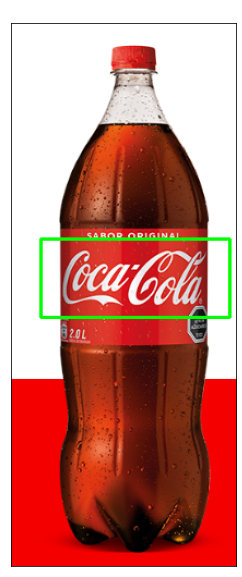

Factor de Escala Final de la Imagen=  1.8948
Rango de Factotores de Escala [min,max,step] =  1.81 4 0.09
Relacion de aspecto =  0.95
Valor Funcion Objetivo =  0.07186449319124222


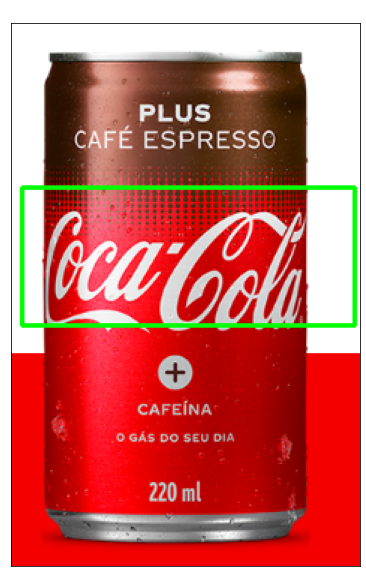

Factor de Escala Final de la Imagen=  0.7253
Rango de Factotores de Escala [min,max,step] =  0.59 4 0.14
Relacion de aspecto =  1.05
Valor Funcion Objetivo =  0.10389731079339981


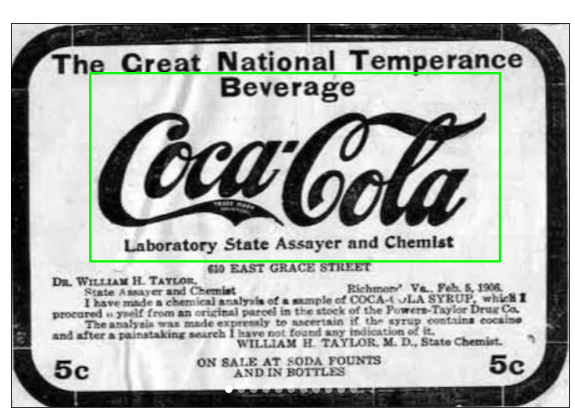

Factor de Escala Final de la Imagen=  2.6356
Rango de Factotores de Escala [min,max,step] =  0.59 4 0.14
Relacion de aspecto =  0.95
Valor Funcion Objetivo =  0.1564222127199173


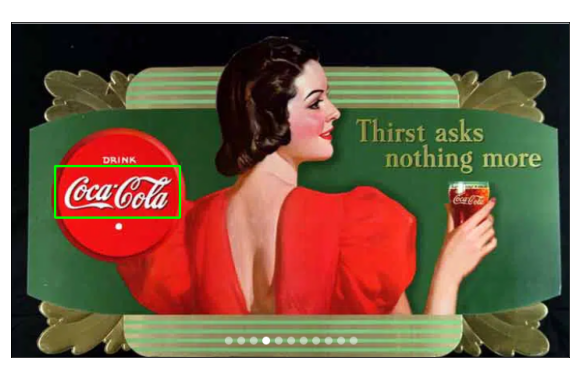

Factor de Escala Final de la Imagen=  3.8611
Rango de Factotores de Escala [min,max,step] =  0.53 4 0.14
Relacion de aspecto =  1.05
Valor Funcion Objetivo =  0.12185902893543243


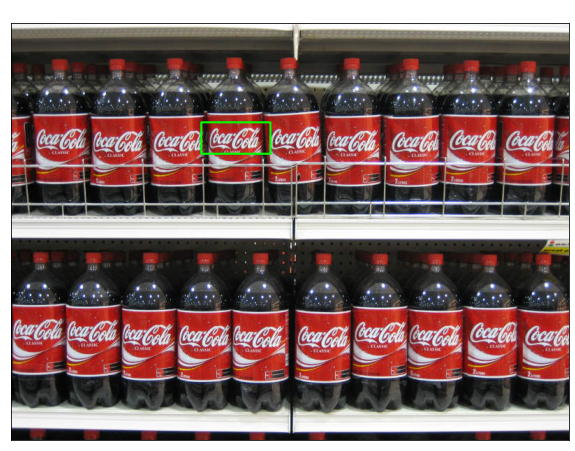

Factor de Escala Final de la Imagen=  1.2903
Rango de Factotores de Escala [min,max,step] =  0.61 4 0.14
Relacion de aspecto =  1.05
Valor Funcion Objetivo =  0.11317385733127594


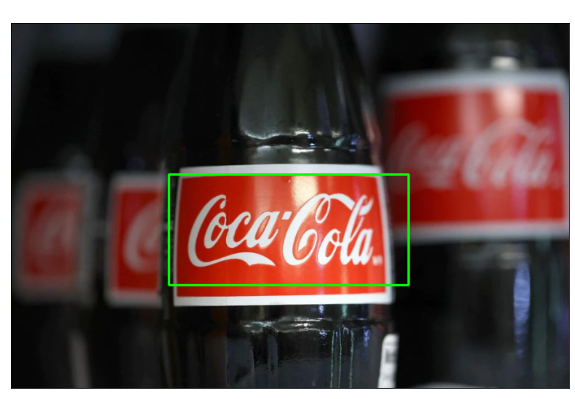

Factor de Escala Final de la Imagen=  0.3031
Rango de Factotores de Escala [min,max,step] =  0.3 4 0.15
Relacion de aspecto =  1.05
Valor Funcion Objetivo =  0.10941989719867706


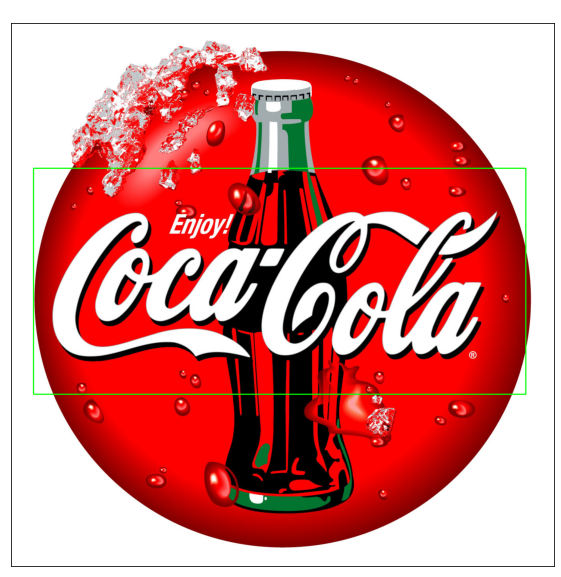

In [22]:
# Cargamos las imagenes y el template a analizar
img1 = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\coca_logo_1.png')
img2 = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\coca_logo_2.png')
img3 = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\coca_retro_1.png')
img4 = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\coca_retro_2.png')
img5 = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\coca_multi.png')
img6 = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\logo_1.png')
img7 = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\COCA-COLA-LOGO.jpg')
img = [img1, img2, img3, img4, img5, img6, img7]

templ = cv.imread('C:/Users\juana\OneDrive\Documentos\IA\CEIA\VPC1\Material_TPs\TP3\images\pattern.png')

# Iteramos sobre cada imagen
for i in img:
    top_left,bottom_right = single_detection(i, templ)
    single_ploteo(i,top_left,bottom_right)